# Modeling (Take 3):

In [1]:
from pathlib import Path
import sys
sys.path.append(str(Path.cwd().parents[0]))
import pandas as pd
import numpy as np
import sqlalchemy as db

from config import Config


engine = db.create_engine(Config.SQLALCHEMY_DATABASE_URI)
conn = engine.connect()
metadata = db.MetaData()

# Training/Testing Data:

- Initial Questions:
    1. What features can be engineered both with ewg data as well as amazon data?
    2. How effectively can we map the ingredients to those collected from aws?
    3. What would be better in this case? Regression or classification?

In [2]:
metadata = db.MetaData(schema='crawled_data')
ewg = db.Table('ewg_product', metadata, autoload=True, autoload_with=engine)

#query = db.select([ewg.columns.product_name, ewg.columns.company, ewg.columns.ingredient, ewg.columns.ingredient_score, ewg.columns.product_score])
query = db.select([ewg])
result = conn.execute(query).fetchall()

ewg_db = pd.DataFrame(result, columns = ewg.columns.keys())
ewg_db

,id,ingredient_score,data_availability,ingredient,ingredient_concerns,product_name,company,product_url,product_score
0,1,1,Robust,WATER,[],Lightly Foaming Vegan Face Wash for Normal/Se...,Just the Goods,https://www.ewg.org/skindeep/products/765576-J...,verified
1,2,1,Limited,POTASSIUM OLEATE,"['Multiple, additive exposure sources (low)']",Lightly Foaming Vegan Face Wash for Normal/Se...,Just the Goods,https://www.ewg.org/skindeep/products/765576-J...,verified
2,3,1,Fair,POTASSIUM COCOATE,"['Irritation (skin, eyes, or lungs) (low)']",Lightly Foaming Vegan Face Wash for Normal/Se...,Just the Goods,https://www.ewg.org/skindeep/products/765576-J...,verified
3,4,1,Good,GLYCERIN,[],Lightly Foaming Vegan Face Wash for Normal/Se...,Just the Goods,https://www.ewg.org/skindeep/products/765576-J...,verified
4,5,1,Limited,POTASSIUM CITRATE,[],Lightly Foaming Vegan Face Wash for Normal/Se...,Just the Goods,https://www.ewg.org/skindeep/products/765576-J...,verified
...,...,...,...,...,...,...,...,...,...
22327,22328,1,Limited,SODIUM COCOYL GLUTAMATE,['Use restrictions (low)'],SkinActive Deep Pore Facial Cleanser,Garnier,https://www.ewg.org/skindeep/products/867661-G...,4
22328,22329,1,Limited,SODIUM PHYTATE,"['Cancer (low)', 'Non-reproductive organ syste...",SkinActive Deep Pore Facial Cleanser,Garnier,https://www.ewg.org/skindeep/products/867661-G...,4
22329,22330,1,Fair,MALTODEXTRIN,[],SkinActive Deep Pore Facial Cleanser,Garnier,https://www.ewg.org/skindeep/products/867661-G...,4
22330,22331,1,Fair,ETHANOL,"['Enhanced skin absorption', 'Non-reproductive...",SkinActive Deep Pore Facial Cleanser,Garnier,https://www.ewg.org/skindeep/products/867661-G...,4


## Feature Engineering:
    - average ingredient score given from EWG
    - average number of concerns for this ingredient (from EWG)
    - encoded brand and ingredient (use saved ingredient/brand list to do so
    - number of ingredients provided for the associated product (varies from product to product)
    - average score of ingredients in the product which that ingredient instance was found

In [3]:
ingredients = ewg_db['ingredient'].unique()

def ingredient_avg_score(ingredients: list) -> dict:
    """Creates a mapping for all ingredients in training set to the average ingredient score"""
    ingred_map = dict()
    for mapval, ingred in enumerate(ingredients):
        unique = ewg_db[ewg_db['ingredient'] == ingred]['ingredient_score'].unique()
        ingred_map[ingred] = np.average(unique)
        #print(f"{ingred}: {unique}")

    return ingred_map

def map_to_int(column: set) -> dict:
    """Takes set of column values and creates a mapping to integers"""
    column_map = dict()
    
    for mapval, val in enumerate(column):
        if val is not None:
            column_map[val.lower().strip()] = mapval
    return column_map

def encode_with_dict(values: list, mapper: dict) -> list:
    """
    Encode values with mapping dictionary, taking into account values which may not appear in dict
    
    Production purposes to anticipate brands/ingredients which haven't been seen before
    """
    
    new_vals = []
    # Give unknown values their own encoding
    unk = max(mapper.values()) + 1
    
    for val in values:
        new_val = mapper[val] if val in mapper.keys() else unk
        new_vals.append(new_val)
        
    return new_val

In [4]:
ml_df = ewg_db[['product_name', 'company', 'ingredient', 'ingredient_score', 'ingredient_concerns', 'product_score']].copy()

# map ingredient list values to the average
ing_score_map = ingredient_avg_score(ml_df['ingredient'].unique())
ml_df['ingredient_score_avg'] = ml_df['ingredient'].map(lambda x: ing_score_map[x])

In [5]:
# Encode brand to a value
brand_enc = map_to_int(set(ml_df['company']))
ml_df['brand_enc'] = ml_df['company'].map(lambda x: brand_enc[x.lower().strip()] if x is not None else 9999999)

In [6]:
# Encode 'verified' brand name into 0
ml_df['product_score'] = ml_df['product_score'].map(lambda x: 0 if x == 'verified' else int(x))
ml_df['product_name'] = ml_df['product_name'].map(lambda x: x.strip())

In [7]:
# Encode ingredient names into values
ing_enc = map_to_int(set(ml_df['ingredient']))
ml_df['ing_enc'] = ml_df['ingredient'].map(lambda x: ing_enc[x.lower().strip()] if x is not None else 9999999)

In [10]:
# Create the following product-centric features:
    # Average ingredient score for corresponding product
    # The number of ingredients shown for the product
    # The number of concerns that the ingredient gives
avg_ingred_score_prod = ml_df.groupby('product_name')['ingredient_score_avg'].mean()
num_ingred = ml_df.groupby('product_name')['ingredient'].count()
ingredient_concern_count = ml_df.groupby('ingredient')['ingredient_concerns'].unique() \
                                                  .map(lambda x: x[0].strip().replace('[]', '').split(',')) \
                                                  .map(lambda x: len(x) if len(x[0]) > 1 else 0)

prod_dict = dict()
ingred_dict = dict()
for i in avg_ingred_score_prod.index:
    prod_dict[i] = (avg_ingred_score_prod[i], num_ingred[i])
    
for i in ingredient_concern_count.index:
    ingred_dict[i] = ingredient_concern_count[i]
    
ml_df['prod_ingredient_score_avg'] = ml_df['product_name'].map(lambda x: prod_dict[x.strip()][0])
ml_df['num_ingredients_product'] = ml_df['product_name'].map(lambda x: prod_dict[x.strip()][1])
ml_df['ingredient_concern_count'] = ml_df['ingredient'].map(lambda x: ingred_dict[x])

In [11]:
ml_df = ml_df.drop(['product_name', 'company', 'ingredient', 'ingredient_concerns', 'ingredient_score'], axis=1)

## Final Engineered Dataframe:

In [12]:
ml_df

,product_score,ingredient_score_avg,brand_enc,ing_enc,prod_ingredient_score_avg,num_ingredients_product,ingredient_concern_count
0,0,1.0,151,56,1.125000,8,0
1,0,1.0,151,1054,1.125000,8,2
2,0,1.0,151,2320,1.125000,8,3
3,0,1.5,151,1908,1.125000,8,0
4,0,1.0,151,2273,1.125000,8,0
...,...,...,...,...,...,...,...
22327,4,1.0,133,803,1.714286,21,1
22328,4,1.0,133,1940,1.714286,21,5
22329,4,1.0,133,334,1.714286,21,0
22330,4,1.5,133,798,1.714286,21,2


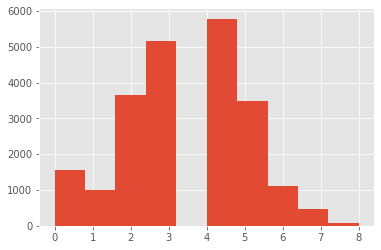

In [13]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

plt.hist(ml_df['product_score']);

## Split the data:

In [14]:
from sklearn.model_selection             import train_test_split

col_list = list(ml_df.columns)
target = 'product_score'
col_list.remove(target)

X_train, X_test, y_train, y_test = train_test_split(ml_df[col_list], ml_df[target])

## Base Model:

In [15]:
from sklearn.linear_model                import LogisticRegression
from sklearn.ensemble                    import RandomForestClassifier
from sklearn.metrics                     import accuracy_score, f1_score

base_model = LogisticRegression(max_iter=1000, multi_class='ovr')
base_model.fit(X_train, y_train)
y_pred = base_model.predict(X_test)

accuracy_score(y_test, y_pred)

0.25291062152964355

## Random Forest Classifier

In [16]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average='weighted')

(0.9729536091706967, 0.9729545224728149)

In [17]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       398
           1       0.99      0.93      0.96       257
           2       0.96      0.98      0.97       938
           3       0.98      0.98      0.98      1272
           4       0.96      0.97      0.97      1388
           5       0.98      0.96      0.97       910
           6       0.99      0.97      0.98       306
           7       1.00      1.00      1.00        97
           8       1.00      1.00      1.00        17

    accuracy                           0.97      5583
   macro avg       0.98      0.97      0.98      5583
weighted avg       0.97      0.97      0.97      5583



## Production:

- We'll only be given ingredients list and ~possibly~ brand name. What can we do with this?

- Findings:
    1. 144 of our products don't have an ingredient list.. What do we do if these are queried?
        - Check for brand name and see if we can extrapolate?

In [18]:
metadata = db.MetaData(schema='cached_data')
amz_prod = db.Table('amazon_product_500', metadata, autoload=True, autoload_with=engine)

query = db.select([amz_prod])
result = conn.execute(query).fetchall()

amz_database = pd.DataFrame(result, columns = amz_prod.columns.keys())
len(amz_database[amz_database['ingredient'] == 'Not Available']['product_link'].values)

144

In [19]:
use_case = amz_database.iloc[2]['ingredient'].split(':')[1].split(',')
use_case = [x.lower().strip() for x in use_case]
use_case

['water',
 'mineral oil',
 'isopropyl palmitate',
 'petrolatum',
 'glycerin',
 'stearic acid',
 'ceresin',
 'glyceryl stearate',
 'cetyl alcohol',
 'sorbitan oleate',
 'candelilla wax',
 'triethanolamine',
 'laureth-23',
 'fragrance',
 'carbomer',
 'disodium edta',
 'dmdm hydantoin',
 'methylparaben',
 'iodopropynyl butylcarbamate.']

In [83]:
brand = amz_database.iloc[2]['brand']

def predict_product_score(ingredient_list, brand, ing_enc=ing_enc, ing_score_map=ing_score_map, brand_enc=brand_enc, ml_df=ml_df, rf=rf):
    rows = []

    for ingredient in ingredient_list:
        # in case the ingredient is not found, just continue and use what we do have!
        try:
            ing_encode = ing_enc[ingredient.lower()]
            ing_score = ing_score_map[ingredient.upper()]
            brand_num = brand_enc[brand.lower()] if brand.lower() in brand_enc.keys() else max(brand_enc.values()) + 1
            ingredient_concern_count = ml_df[ml_df['ing_enc'] == ing_score]['ingredient_concern_count'].max()
            if type(ingredient_concern_count) == float: ingredient_concern_count = 0   # Get rid of pesky NaN's (since numbered vals will be integers)
            rows.append([ing_encode, ing_score, brand_num, ingredient_concern_count])
        except:
            continue

    features = pd.DataFrame(rows, columns=['ing_enc', 'ingredient_score_avg', 'brand_enc', 'ingredient_concern_count'])
    features['num_ingredients_product'] = len(features)
    features['prod_ingredient_score_avg'] = features['ingredient_score_avg'].mean()
    features = features[col_list]
    
    # In case none of the ingredients are found (or ingredient list isn't given)
    if len(features) == 0:
        return np.nan

    #print(features)
    prediction = rf.predict(features)
    pooled_prediction = mode(prediction).mode[0]
    
    return pooled_prediction

In [84]:
predict_product_score(use_case, brand)

4

## Use Case #2:

In [85]:
use_case_2 = amz_database.iloc[503]['ingredient'].split(',')
use_case_2 = [i.strip() for i in use_case_2]
brand_2 = amz_database.iloc[503]['brand']

predict_product_score(ingredient_list=use_case_2, brand=brand_2)

5

In [82]:
ing_enc['Phenoxyethanol'.lower()]

1711

In [89]:
ingredients = amz_database['ingredient']
brands = amz_database['brand']

score_preds = []

for i, b in zip(ingredients, brands):
    i = i.split(',')
    i = [val.strip() for val in i]
    
    score = predict_product_score(ingredient_list=i, brand=b)
#    if type(score) == float:
#         print(i)
#         print(score)
    score_preds.append(score)
    
len(score_preds)

508

In [92]:
len([i for i in score_preds if str(i) != 'nan'])

264

## Table for Predictions:

- currently populated with "fake" data

In [13]:
metadata = db.MetaData(schema='cached_data')
amz = db.Table('amz_score', metadata, autoload=True, autoload_with=engine)

query = db.select([amz])
conn.execute(query).fetchall()

[('B000GF1E54', 4),
 ('B01B3QIEPC', 4),
 ('B00GXOISA6', 1),
 ('B00CBGALH8', 2),
 ('B004JKNYL4', 0),
 ('B014P8F7EG', 1),
 ('B083VQJM6B', 10),
 ('B07ZDH8PWN', 1),
 ('B06X9ZCFG4', 7),
 ('B072L2344Z', 2),
 ('B008P5E9M2', 3),
 ('B07D3W6B83', 2),
 ('B07WTF9WSM', 8),
 ('B00JKMPAUE', 4),
 ('B01AFG8FOQ', 5),
 ('B00TMTAOLA', 6),
 ('B007K8Q6P8', 9),
 ('B00EQWWYQ6', 4),
 ('B001IM5VT4', 3),
 ('B07ZVYMCG8', 3),
 ('B00C9O4EHA', 6),
 ('B00006FRW7', 10),
 ('B00B4PWEJU', 4),
 ('B000E3BZUW', 8),
 ('B00CWY8OC8', 3),
 ('B018A0MGH6', 4),
 ('B07K3XRCGD', 0),
 ('B01N8QHSED', 10),
 ('B07HZWXGJ7', 2),
 ('B08PBHF24J', 7),
 ('B07S6YHFDH', 0),
 ('B017NPGC7O', 10),
 ('B001JF0MRG', 9),
 ('B01LZAN652', 3),
 ('B0000C4COW', 5),
 ('B003YCH216', 5),
 ('B000OUTTP8', 0),
 ('B01M345Z4K', 2),
 ('B0009ET6BQ', 1),
 ('B0012J30LY', 6),
 ('B01F7K6Y9S', 0),
 ('B019LF1BOS', 2),
 ('B07NMHC86M', 6),
 ('B07P98JBRR', 8),
 ('B07YQ5Z65X', 1),
 ('B07XFLYN6X', 4),
 ('B004R7N5AE', 6),
 ('B001F0H77I', 4),
 ('B000052ZB8', 1),
 ('B089SYRP8T', 